In [1]:
using Revise
using LinearAlgebra
using SparseArrays
using Pkg
using DelayDiffEq 
using Plots
using BenchmarkTools

In [2]:
using OpenQuantumSystems

┌ Info: Precompiling OpenQuantumSystems [90e503ea-487f-4e8e-81fe-8dcc9db25ac5]
└ @ Base loading.jl:1342


In [3]:
D(op1::Array, op2::Array) = abs(norm(op1 - op2))
D(x1::StateVector, x2::StateVector) = norm(x2 - x1)
D(op1::AbstractOperator, op2::AbstractOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))
D(op1::AbstractSuperOperator, op2::AbstractSuperOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))

HR = 0.01
shift = (2.0 * HR)
modes = [Mode(180., shift)]
mols = [
        Molecule([Mode(180., shift)], 3, [12500., 12700.]),
        Molecule([Mode(180., shift)], 3, [12500., 12700.])
    ]

aggCore = AggregateCore(mols)
for mol_i in 2:aggCore.molCount
    aggCore.coupling[mol_i, mol_i+1] = 50
    aggCore.coupling[mol_i+1, mol_i] = 50
end
agg = setupAggregate(aggCore)
aggCore = agg.core
aggTools = agg.tools
aggOperators = agg.operators

Ham_sys = agg.operators.Ham_sys
Ham_bath = agg.operators.Ham_bath
Ham_S = agg.operators.Ham_S
Ham_B = agg.operators.Ham_B
Ham_I = agg.operators.Ham_I
Ham_0 = agg.operators.Ham_0
Ham = agg.operators.Ham

basis = agg.tools.basis
indicesLen = agg.tools.bSize
indices = agg.tools.indices
indicesMap = agg.tools.indicesMap
FCFact = agg.tools.FCfactors
FCProd = agg.tools.FCproduct

Ham_0
Ham_0_lambda, Ham_0_S = eigen(Ham_0.data)
Ham_0_Sinv = inv(Ham_0_S)
Ham_0_lambda = diagm(Ham_0_lambda)
println("")

In [4]:
t_max = 0.05
t_count = 200
t0 = 0.
t_step = (t_max - t0) / (t_count)
tspan = [t0:t_step:t_max;]

T = 300
mu_array = [[2, 1]]
W0_1 = thermal_state(T, [[2, 1]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_2 = thermal_state(T, [[1, 2]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_3 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
W0_4 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
a1 = indicesMap[2][1]; a2 = indicesMap[2][end]
b1 = indicesMap[3][1]; b2 = indicesMap[3][end]
W0_3.data[a1:a2, b1:b2] = W0_2.data[b1:b2, b1:b2]
W0_4.data[b1:b2, a1:a2] = W0_2.data[b1:b2, b1:b2]
W0 = 0.8*W0_1 + 0.2*W0_2 + 0.1*W0_3 + 0.1*W0_4
W0 = DenseOperator(W0.basis_l, W0.basis_r, complex(W0.data))

# data = Matrix(Hermitian(rand(ComplexF64, indicesLen, indicesLen)))
# W0 = DenseOperator(basis, basis, data)
# normalize!(W0)

W0_bath = get_rho_bath(W0, aggCore, aggTools)
W0_bath = DenseOperator(W0_bath.basis_l, W0_bath.basis_r, complex(W0_bath.data))

rho0 = trace_bath(W0, aggCore, aggTools)
rho0 = DenseOperator(rho0.basis_l, rho0.basis_r, complex(rho0.data))

println("")

In [26]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 5
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60
using OpenQuantumSystems
@time T, rho_int_t = QME_sS_exact(
    W0,
    tspan,
    agg;
    reltol = 1e-3,
    abstol = 1e-3,
    int_reltol = 1e-4,
    int_abstol = 1e-4,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Tsit5()),
)

316.395002 seconds (16.74 M allocations: 108.860 GiB, 1.06% gc time)


([0.0, 0.00025, 0.0005, 0.00075, 0.001, 0.00125, 0.0015, 0.00175, 0.002, 0.00225  …  0.04775, 0.048, 0.04825, 0.0485, 0.04875, 0.049, 0.04925, 0.0495, 0.04975, 0.05], Operator{GenericBasis{Vector{Int64}}, GenericBasis{Vector{Int64}}, Matrix{ComplexF64}}[Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im        0.0+0.0im
 0.0+0.0im   0.799839+0.0im  0.0999399+0.0im
 0.0+0.0im  0.0999399+0.0im    0.19996+0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im               0.0+0.0im
 0.0+0.0im   0.799745-0.0im         0.0999399+0.00749677im
 0.0+0.0im  0.0999399-0.00749677im   0.200055-0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im              0.0+0.0im
 0.0+0.0im   0.799461-0.0im        0.0999399+0.0149896im
 0.0+0.0im  0.0999399-0.0149896im   0.200338-0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im       0.0+0.0im             0.0+0.0im
 0.0+0.0im  0.798989-0.0im         0.09994+0.0224734im
 0.0+0.0im   0.09994-0

In [29]:
W_t_exact = zeros(ComplexF64, length(tspan), agg.tools.bSize, agg.tools.bSize)
t_i = 0

for t_i in 1:length(tspan)
    t = tspan[t_i]
    U_op = evolutionOperator(Ham, t)
    W = U_op * W0 * U_op'
    # U_0_op = evolutionOperator(Ham_0, t)
    # W_int = U_0_op' * W * U_0_op
    W_t_exact[t_i, :, :] = W.data
end

1 0.0
2 1.6634126384607731e-6
3 6.0651200399154335e-6
4 1.2402834090820915e-5
5 1.99823078972627e-5
6 2.8219529565162862e-5
7 3.664492861198424e-5
8 4.4910096750677886e-5
9 5.2797324423330495e-5
10 6.02315567525457e-5
11 6.729273498859382e-5
12 7.422350795293953e-5
13 8.142336920901472e-5
14 8.941799612056151e-5
15 9.8797109715008e-5
16 0.00011012881420887128
17 0.00012387586049300426
18 0.00014034293891458741
19 0.00015966724382819952
20 0.00018184217165237763
21 0.00020675435531542305
22 0.00023421875823463706
23 0.0002640054595782461
24 0.00029585792286680615
25 0.00032950490648826146
26 0.00036466833294415745
27 0.00040106884356027776
28 0.00043843013482308907
29 0.0004764827101824189
30 0.0005149673903944477
31 0.000553638756942706
32 0.0005922686111956866
33 0.0006306494834830053
34 0.0006685982024473988
35 0.0007059595237352286
36 0.0007426098130004067
37 0.0007784607766770814
38 0.0008134632347485321
39 0.0008476109304450181
40 0.000880944372881027
41 0.0009135547091765591
42 0

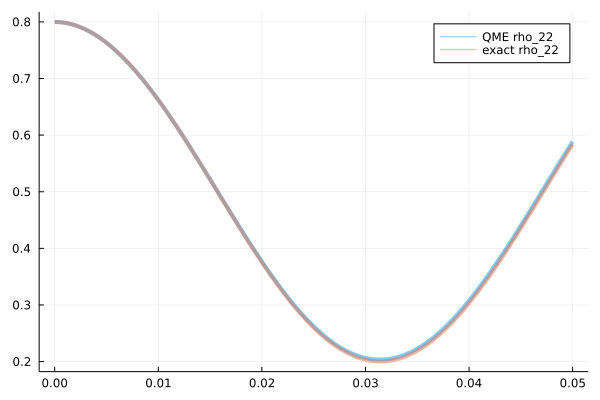

In [30]:

elLen = aggCore.molCount
rho_t = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t_exact = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)

for t_i in 1:length(tspan)
    rho_t[t_i, :, :] = rho_int_t[t_i].data
    # rho_t[t_i, :, :] = trace_bath(W_int_t[t_i].data, aggCore, aggTools)
    rho_t_exact[t_i, :, :] = trace_bath(W_t_exact[t_i, :, :], aggCore, aggTools)
    println(t_i, " ", D(rho_t[t_i, :, :], rho_t_exact[t_i, :, :]))
end

plot(tspan, real(rho_t[:, 2, 2]), label="QME rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t_exact[:, 2, 2]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)

In [6]:
using OpenQuantumSystems
include("test_master_exact.jl")


Test Summary: |
master        | No tests


Test.DefaultTestSet("master", Any[], 0, false, false)

In [8]:
names = [
    "test_operators_dense.jl",
    "test_superoperators.jl",
    "test_metrics.jl",
    "test_molecules.jl",
    "test_aggregateCore.jl",
    "test_aggregateTools.jl",
    "test_aggregateOperators.jl",
    "test_aggregate.jl",
    "test_evolution.jl",
    "test_schroedinger.jl",
    "test_liouville.jl",
    "test_interaction_picture.jl",
    "test_master_exact.jl",
    "test_trace.jl",
    "test_initial_state.jl",
    "test_memory_kernel.jl",
    "test_master_ansatz.jl",
]

for name in names
    include(name)
end

Test Summary:   | Pass  Total
operators dense |    6      6
Test Summary:  | Pass  Total
superoperators |    2      2
Test Summary: | Pass  Total
metrics       |   19     19
Test Summary: | Pass  Total
molecules     |   20     20
Test Summary: | Pass  Total
aggregateCore |   14     14
Test Summary:  | Pass  Total
aggregateTools |   12     12
Test Summary:      | Pass  Total
aggregateOperators |    7      7
Test Summary: | Pass  Total
aggregate     |    3      3
Test Summary: | Pass  Total
evolution     |   54     54
Test Summary: | Pass  Total
schroedinger  |   25     25
Test Summary: | Pass  Total
liouville     |   11     11
Test Summary:       | Pass  Total
interaction picture |    9      9
Test Summary: |
master        | No tests
Test Summary: | Pass  Total
trace         |   41     41
Test Summary: | Pass  Total
initial state |    8      8
Test Summary: | Pass  Total
memory kernel |   51     51
Test Summary: |
master ansatz | No tests
